# Capstone

## Problem Statement

How accurately can the outcome of a chess game (winner or loser) be predicted by a neural network using only the moves played?

## Executive Summary

This project examines a data set of 20,000 chess games and tries to predict the outcome using a neural network and only the moves played. The moves are in a PGN format, so work needs to be done in order to prepare them for modeling. Data cleaning and preprocessing sections of this notebook handle that by putting the moves into split lists, putting those lists into an array, then tokenizing all unique moves. In addition, exploratory data analysis is conducted in order to gain a better understanding of the data and look into potential concepts to include into the model. Examples of EDA include looking at the distribution of game outcomes, a histogram of average ratings, and examining the most popular chess openings used by all and highly skilled players.

Two neural networks are utilized: an LSTM model and a GRU model. These two models are very similar to each other, but have a few key differences. In the end, the GRU model performs better than the LSTM model; however, both end up being decent models (although the GRU ends up being excellent). The LSTM model is a bit more complex in nature, as more layers were added to it, which can be observed in the notebook. Finally, conclusions, findings, and recommendations are presented based on the model evaluation.

### Contents:
- [Imports](#Imports)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#EDA)
- [Preprocessing](#Preprocessing)
- [Modeling (LSTM)](#Modeling-(LSTM)
- [Modeling (GRU)](#Modeling-(GRU)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Imports

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from itertools import islice

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

from keras import Model
from keras import Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import GRU, Dense, LSTM, Conv1D, Masking, Dropout, Flatten, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.metrics import AUC
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [197]:
# Disabling TensorFlow warnings, improving readability of notebook
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Reading in the data
df = pd.read_csv('./data/games.csv')

In [3]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [5]:
# Checking for nulls
df.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [6]:
# Examining moves format more closely
print(df['moves'][2])
print(df['moves'][:5])

e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc6 bxc6 Ra6 Nc4 a4 c3 a3 Nxa3 Rxa3 Rxa3 c4 dxc4 d5 cxd5 Qxd5 exd5 Be6 Ra8+ Ke7 Bc5+ Kf6 Bxf8 Kg6 Bxg7 Kxg7 dxe6 Kh6 exf7 Nf6 Rxh8 Nh5 Bxh5 Kg5 Rxh7 Kf5 Qf3+ Ke6 Bg4+ Kd6 Rh6+ Kc5 Qe3+ Kb5 c4+ Kb4 Qc3+ Ka4 Bd1#
0    d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...
1    d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...
2    e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...
3    d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...
4    e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...
Name: moves, dtype: object


In [7]:
# Checking descriptive statistics to potentially influence cleaning and gain better understanding of data
df['opening_ply'].describe()

count    20058.000000
mean         4.816981
std          2.797152
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         28.000000
Name: opening_ply, dtype: float64

In [8]:
df['white_rating'].describe()

count    20058.000000
mean      1596.631868
std        291.253376
min        784.000000
25%       1398.000000
50%       1567.000000
75%       1793.000000
max       2700.000000
Name: white_rating, dtype: float64

In [9]:
df['black_rating'].describe()

count    20058.000000
mean      1588.831987
std        291.036126
min        789.000000
25%       1391.000000
50%       1562.000000
75%       1784.000000
max       2723.000000
Name: black_rating, dtype: float64

In [10]:
df['turns'].describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

In [11]:
df['victory_status'].unique()

array(['outoftime', 'resign', 'mate', 'draw'], dtype=object)

In [12]:
df['winner'].unique()

array(['white', 'black', 'draw'], dtype=object)

In [13]:
df['opening_name'].nunique()

1477

In [14]:
df[df['white_rating'] > 2000]['rated'].sum()

1377

In [15]:
# Dropping unnecessary columns
df.drop(columns = ['id', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id'], inplace = True)

In [16]:
# Splitting all the lists
for i in range(len(df['moves'])):
    df['moves'][i] = df['moves'][i].split()

<ipython-input-16-9688ccc74b77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moves'][i] = df['moves'][i].split()


## EDA

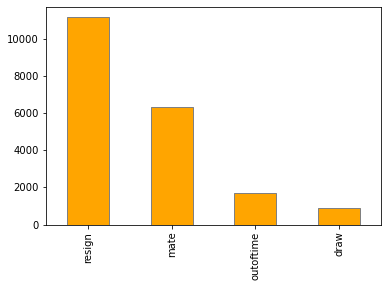

In [258]:
# Plotting bar graph of outcomes
df['victory_status'].value_counts()[:4].plot(kind='bar', color = 'orange', edgecolor = 'gray');
plt.savefig('Outcomes.png')

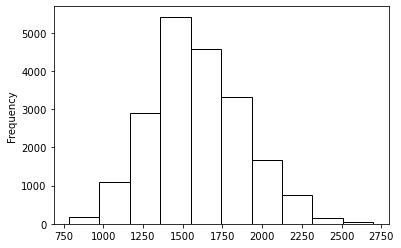

In [259]:
# White ratings histogram
df['white_rating'].plot(kind='hist', color = 'white', edgecolor = 'black');
plt.savefig('White_Rating.png')

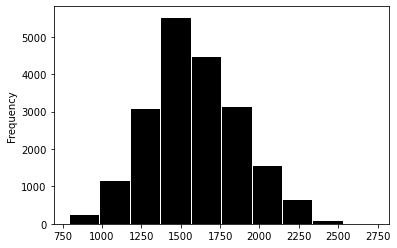

In [260]:
# Black ratings histogram
df['black_rating'].plot(kind='hist', color = 'black', edgecolor = 'white');
plt.savefig('Black_Rating.png')

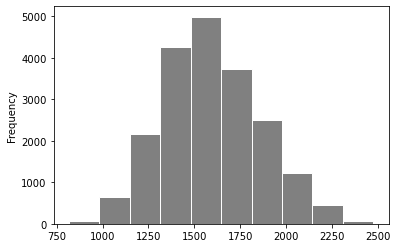

In [263]:
# Plotting average rating histogram
df['average_rating'] = (df['white_rating'] + df['black_rating']) / 2
df['average_rating'].plot(kind = 'hist', color = 'gray', edgecolor = 'white')
plt.savefig('Average_Overall_Rating.png')
df.drop(columns = ['average_rating'], inplace = True);

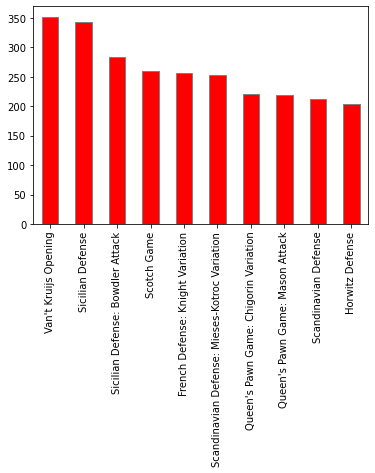

In [256]:
# Plots the top 10 most commonly used openings
df['opening_name'].value_counts()[:10].plot(kind='bar', color = 'red', edgecolor = 'gray');
plt.savefig('Popular_Openings_All_Players.png')

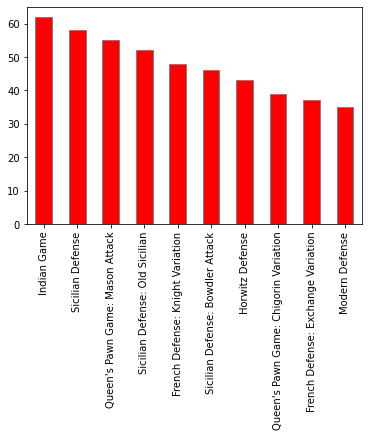

In [255]:
# Plots the top 10 most commonly used openings from highly skilled players
df[(df['white_rating'] > 1700) & (df['black_rating'] > 1700)]['opening_name'].value_counts()[:10].plot(kind='bar', color = 'red', edgecolor = 'gray');
plt.savefig('Popular_Openings_Skilled_Players.png')

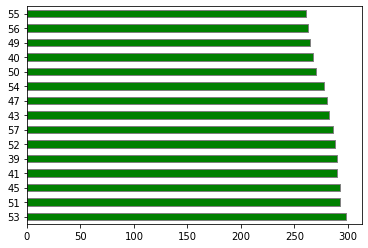

In [247]:
# Plots the 15 most common turn lengths for games with more than 15 turns
df[(df['turns'] > 15)]['turns'].value_counts()[:15].plot(kind='barh', color = 'green', edgecolor = 'gray');

In [280]:
np.round(df['turns'].mean())

59.0

## Preprocessing

In [16]:
# Getting rid of draw outcomes to improve model accuracy (tested with draws, which reduced accuracy)
df = df[df['winner'] != 'draw']

In [17]:
df.shape

(19108, 10)

In [18]:
# Recalibrating index due to dropped draws
df = df.reset_index()
df.drop(columns = ['index'])

,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,13,outoftime,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,16,resign,black,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,61,mate,white,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,61,mate,white,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,95,mate,white,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
...,...,...,...,...,...,...,...,...,...,...
19103,True,24,resign,white,1691,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2
19104,True,82,mate,black,1233,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2
19105,True,35,mate,white,1219,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3
19106,True,109,resign,white,1360,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4


In [19]:
# Setting up target column
df['target'] = 0

In [20]:
# Assigning values to target column
for i in range(len(df)):
    if df['winner'][i] == 'white':
        df['target'][i] = 0
    else:
        df['target'][i] = 1

<ipython-input-20-b7f3c48db9f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][i] = 0
<ipython-input-20-b7f3c48db9f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][i] = 1


In [21]:
df.tail()

,index,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,target
19103,20053,True,24,resign,white,1691,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2,0
19104,20054,True,82,mate,black,1233,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2,1
19105,20055,True,35,mate,white,1219,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3,0
19106,20056,True,109,resign,white,1360,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4,0
19107,20057,True,78,mate,black,1235,1339,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,D00,Queen's Pawn Game: Mason Attack,3,1


In [22]:
# Making an array of lists for moves
moves = np.array(df['moves'])

In [23]:
moves

array(['d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4',
       'd4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ Nxe5 c4 Bb4+',
       'e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc6 bxc6 Ra6 Nc4 a4 c3 a3 Nxa3 Rxa3 Rxa3 c4 dxc4 d5 cxd5 Qxd5 exd5 Be6 Ra8+ Ke7 Bc5+ Kf6 Bxf8 Kg6 Bxg7 Kxg7 dxe6 Kh6 exf7 Nf6 Rxh8 Nh5 Bxh5 Kg5 Rxh7 Kf5 Qf3+ Ke6 Bg4+ Kd6 Rh6+ Kc5 Qe3+ Kb5 c4+ Kb4 Qc3+ Ka4 Bd1#',
       ...,
       'd4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd2 b6 Ne5 Nxe5 Bxe5 Nd7 Bxh7+ Kxh7 Qh5+ Kg8 Nf3 f6 Bf4 g5 Qg6+ Kh8 Nh4 Qe8 Qh6+ Kg8 Ng6 Kf7 Qh7#',
       'e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb6 c5 Nd5 Bc4 e6 Bxd5 exd5 Nc3 d4 Ne4 Bf5 f3 Nd7 b4 Nxe5 Bf4 f6 g4 Bxe4 fxe4 c6 Bxe5 fxe5 Nf3 Be7 Nxe5 Bf6 Nc4 O-O-O h4 h6 e5 b5 cxb6 Be7 bxa7 Kc7 a3 Rhf8 Kd2 Rf4 Rag1 d3 h5 Rf2+ Ke3 Re2+ Kf4 Rf8+ Kg3 Re3+ Nxe3 d2 Rd1 Bg5 Nf5 Kb7 Rhf1 Kxa7 Nd6 Rxf1 Rxf1 Kb6 e6 Kc7 Nf5 Kc8 e7 Kd7 a4 Bxe7 Nxe7 Kxe7 a5 Kd7 Rd1 Kc7 Rxd2 Kb7 Ra2 Ka6 Kf4 Kb5 a6 Kb6 a7 Kb5 a8=Q Kxb4 Qxc6 g5+ hxg6 Kb3 Rc

In [24]:
# Making array of target variables
target = np.array(df['target'])

In [25]:
target

array([0, 1, 0, ..., 0, 0, 1])

In [26]:
moves.shape

(19108,)

In [27]:
target.shape

(19108,)

In [28]:
# Declaring max turns for modeling
max_turns = df['turns'].max()

In [74]:
# Making a new list of lists to retrieve number of unique moves
moves_list = []
for i in range(len(df['moves'])):
    moves_list.append(df['moves'][i].split())

In [72]:
moves_list[1][1]

'Nc6'

In [78]:
# source: https://stackoverflow.com/questions/30565759/get-unique-values-in-list-of-lists-in-python
max_unique = len(set(x for l in moves_list for x in l))
print(max_unique)

4373


In [101]:
# source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# Making sure lower is set to false to avoid altering moves data
tokenizer = Tokenizer(num_words = max_unique, lower = False)

In [102]:
# Fitting tokenizer on moves array
tokenizer.fit_on_texts(moves)

In [104]:
# Creating sequences for modeling
move_sequences = tokenizer.texts_to_sequences(moves)

In [107]:
# Previewing sequences
move_sequences[:2]

[[5, 8, 11, 22, 71, 12, 481, 252, 2, 58, 9, 367, 56],
 [5, 7, 3, 6, 19, 48, 62, 158, 158, 41, 161, 7, 169, 41, 11, 58]]

In [120]:
# source: https://stackoverflow.com/questions/7971618/return-first-n-keyvalue-pairs-from-dict
# Using this function to preview dictionary of tokenized moves to validate the process
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

word_dict = tokenizer.word_index
word_dict_first_10 = take(10, word_dict.items())
word_dict_first_10

[('O', 1),
 ('Nf3', 2),
 ('e4', 3),
 ('Nf6', 4),
 ('d4', 5),
 ('e5', 6),
 ('Nc6', 7),
 ('d5', 8),
 ('Nc3', 9),
 ('c5', 10)]

In [121]:
# Using pad sequences to make sequences the same length for modeling
move_sequences_padded = pad_sequences(move_sequences, max_unique)

In [122]:
move_sequences_padded[:2]

array([[  0,   0,   0, ...,   9, 367,  56],
       [  0,   0,   0, ...,  41,  11,  58]], dtype=int32)

In [ ]:
df.to_csv('games_targetd')

## Modeling (LSTM)

In [273]:
# Declaring AUC for LSTM and GRU model evaluation
auc = AUC(name = 'auc')

In [270]:
# source 1: https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
# source 2: https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607
# source 3: https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

# Using sequential model
model_lstm = Sequential()
model_lstm.add(Input(shape = max_turns))
model_lstm.add(Embedding( 
    input_dim = max_unique,
    output_dim = 320,
    input_length = max_turns))

# Masking in an attempt to evaluate padded sequences while discounting the padded values
model_lstm.add(Masking(mask_value = 0.0)) 

# LSTM params designed to improve training efficiency and accuracy
model_lstm.add(LSTM(64, return_sequences = False, dropout = 0.1, recurrent_dropout = 0.1)) 

# First dense layer
model_lstm.add(Dense(64, activation = 'sigmoid'))

# Reduce validation loss
model_lstm.add(Dropout(0.05)) 

# Second dense layer
model_lstm.add(Dense(128, activation = 'sigmoid'))

# Reduce validation loss
model_lstm.add(Dropout(0.2)) 

# Output
model_lstm.add(Dense(1, activation = 'sigmoid')) 

# Compiling model
model_lstm.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',   
              metrics = ['accuracy', auc])

# Training with RLROP and Early Stopping callback
history_lstm = model_lstm.fit(X_train,
                   y_train,
                   validation_data = (X_test, y_test),
                   batch_size = 32,
                   epochs = 10,
                   verbose = 2,
                   callbacks = [ReduceLROnPlateau(), EarlyStopping(monitor = 'val_loss', patience = 5)])

Epoch 1/10
401/401 - 2896s - loss: 0.5486 - accuracy: 0.7190 - auc: 0.7982 - val_loss: 0.5054 - val_accuracy: 0.7564 - val_auc: 0.8366
Epoch 2/10
401/401 - 2743s - loss: 0.4599 - accuracy: 0.7895 - auc: 0.8649 - val_loss: 0.4865 - val_accuracy: 0.7709 - val_auc: 0.8516
Epoch 3/10
401/401 - 2716s - loss: 0.4081 - accuracy: 0.8191 - auc: 0.8958 - val_loss: 0.4863 - val_accuracy: 0.7697 - val_auc: 0.8541
Epoch 4/10
401/401 - 2713s - loss: 0.3622 - accuracy: 0.8446 - auc: 0.9184 - val_loss: 0.4971 - val_accuracy: 0.7758 - val_auc: 0.8579
Epoch 5/10
401/401 - 2724s - loss: 0.3249 - accuracy: 0.8624 - auc: 0.9347 - val_loss: 0.4908 - val_accuracy: 0.7745 - val_auc: 0.8581
Epoch 6/10
401/401 - 2718s - loss: 0.2831 - accuracy: 0.8827 - auc: 0.9503 - val_loss: 0.5393 - val_accuracy: 0.7664 - val_auc: 0.8541
Epoch 7/10
401/401 - 2691s - loss: 0.2392 - accuracy: 0.9053 - auc: 0.9642 - val_loss: 0.5656 - val_accuracy: 0.7764 - val_auc: 0.8574
Epoch 8/10
401/401 - 2691s - loss: 0.2062 - accuracy: 0

In [274]:
model_lstm.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 349, 320)          1399360   
_________________________________________________________________
masking_11 (Masking)         (None, 349, 320)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                98560     
_________________________________________________________________
dense_53 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)             

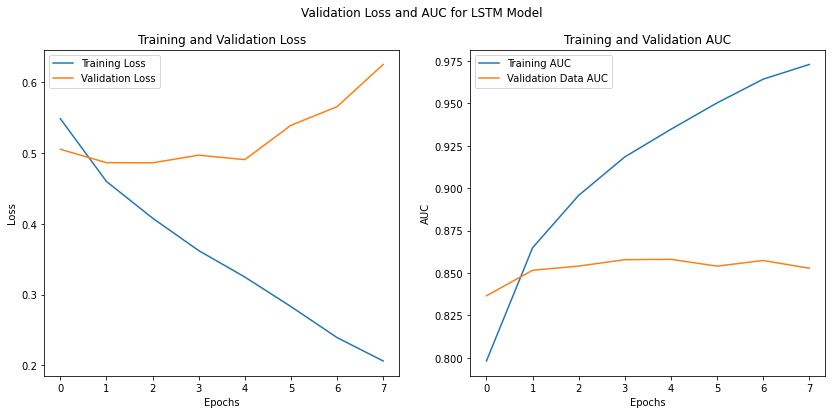

In [272]:
# Setting up subplots
fig, ax = plt.subplots(1, 2, figsize = (14,6))

# Overarching title
fig.suptitle('Validation Loss and AUC for LSTM Model')

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label = 'Training Loss');
plt.plot(history_lstm.history['val_loss'], label = 'Validation Loss');
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['auc'], label = 'Training AUC')
plt.plot(history_lstm.history['val_auc'], label = 'Validation Data AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend();

# Saving figure
plt.savefig('Val_Loss_and_AUC_for_LSTM_Model.png')

In [271]:
# loss, accuracy, auc -- definitely room to improve these results
model_lstm.evaluate(X_test, y_test)

198/198 [==============================] - 177s 892ms/step - loss: 0.6253 - accuracy: 0.7712 - auc: 0.8528


[0.6253229975700378, 0.7711703181266785, 0.8528313040733337]

## Modeling (GRU)

In [124]:
# Establishing training and testing data
X_train, X_test, y_train, y_test = train_test_split(move_sequences_padded, target, test_size = 0.33, random_state = 42)

In [125]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12802, 4373)
(6306, 4373)
(12802,)
(6306,)


In [200]:
# source 1: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
# source 2: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

# Using sequential model
model_gru = Sequential()
model_gru.add(Input(shape = max_turns))

# source 1: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# source 2: https://keras.io/api/layers/core_layers/embedding/
model_gru.add(Embedding( 
    input_dim = max_unique,
    output_dim = 320,
    input_length = max_turns))

# Simple GRU with mostly default parameters but making units equal to embedding amount and adding a very small fraction of dropout
model_gru.add(GRU(units = 320, dropout = 0.001)) 

# Output
model_gru.add(Dense(1, activation = 'sigmoid'))

# Compiling model with standard adam optimizer and bce used in conjunction with sigmoid activation
model_gru.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',  
              metrics = ['accuracy', auc])

# Validation split leads to higher accuracy
# Batch size reference: https://stackoverflow.com/questions/35050753/how-big-should-batch-size-and-number-of-epochs-be-when-fitting-a-model-in-keras
# Verbose reference: https://stackoverflow.com/questions/47902295/what-is-the-use-of-verbose-in-keras-while-validating-the-model
# ReduceLROnPlateau reference: https://keras.io/api/callbacks/reduce_lr_on_plateau
history = model_gru.fit(X_train,
                   y_train,
                   validation_split = .2, 
                   batch_size = 32, 
                   epochs = 7,
                   verbose = 1,
                   callbacks = [ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.001)])

Epoch 1/7
321/321 [==============================] - 4391s 14s/step - loss: 0.5228 - accuracy: 0.7384 - auc: 0.8181 - val_loss: 0.3851 - val_accuracy: 0.8403 - val_auc: 0.9103
Epoch 2/7
321/321 [==============================] - 4075s 13s/step - loss: 0.3259 - accuracy: 0.8639 - auc: 0.9346 - val_loss: 0.3089 - val_accuracy: 0.8696 - val_auc: 0.9422
Epoch 3/7
321/321 [==============================] - 4411s 14s/step - loss: 0.2531 - accuracy: 0.8916 - auc: 0.9611 - val_loss: 0.2800 - val_accuracy: 0.8872 - val_auc: 0.9535
Epoch 4/7
321/321 [==============================] - 4694s 15s/step - loss: 0.1966 - accuracy: 0.9173 - auc: 0.9764 - val_loss: 0.2947 - val_accuracy: 0.8778 - val_auc: 0.9526
Epoch 5/7
321/321 [==============================] - 4751s 15s/step - loss: 0.2638 - accuracy: 0.8897 - auc: 0.9581 - val_loss: 0.5754 - val_accuracy: 0.7103 - val_auc: 0.8282
Epoch 6/7
321/321 [==============================] - 4440s 14s/step - loss: 0.3281 - accuracy: 0.8537 - auc: 0.9338 - va

In [275]:
model_gru.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 349, 320)          1399360   
_________________________________________________________________
gru_19 (GRU)                 (None, 320)               616320    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 321       
Total params: 2,016,001
Trainable params: 2,016,001
Non-trainable params: 0
_________________________________________________________________


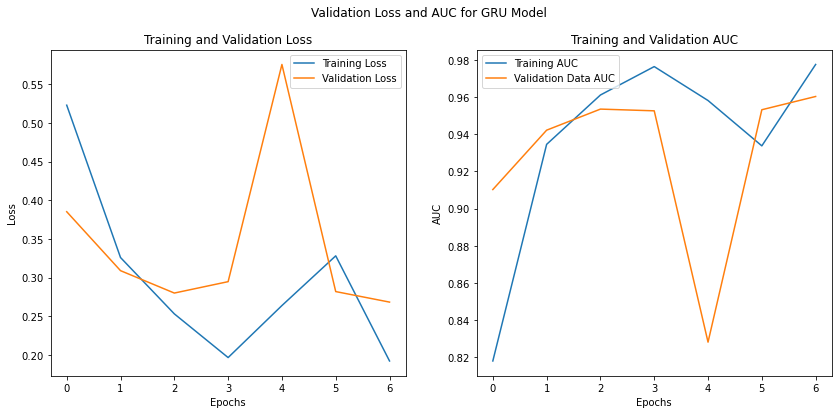

In [253]:
# Setting up subplots
fig, ax = plt.subplots(1, 2, figsize = (14,6))

# Overarching title
fig.suptitle('Validation Loss and AUC for GRU Model')

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss');
plt.plot(history.history['val_loss'], label = 'Validation Loss');
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label = 'Training AUC')
plt.plot(history.history['val_auc'], label = 'Validation Data AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend();

# Saving plot
plt.savefig('Val_Loss_and_AUC_for_GRU_Model.png')

In [202]:
# loss, accuracy, auc -- great evaluation with very high accuracy, could run over more epochs in the future!
model_gru.evaluate(X_test, y_test, verbose = 0)

[0.30783140659332275, 0.8829686045646667, 0.9506576657295227]

## Conclusions and Recommendations

Overall, I would suggest using a GRU model over the LSTM due to its efficiency, its simplicity relative to the LSTM, and its accuracy. From the two types of models shown, it is evident that predicting the outcome of a chess game only using the moves can lead to an excellent model. This is largely due to the fact that chess moves are deep and interrelated, which the models can pick up on and utilize to predict a game's outcome. There is definitely potential for RNNs to be used for positional evaluation, as taking any set of moves and predicting the winner indicates that they can evaluate the position and make a prediction based on it. 

### Moving Forward

There is quite a bit that can be done to move forward with this project. First, I'd like to continue tuning both the GRU and especially the LSTM model to improve performance and workflow. Running both of these models over more epochs can create more convincing plots for training and validation loss and AUC. Conducting a GridSearch to tune and optimize hyperparameters is something I want to incorporate, which can help with model tuning. In addition, looking into other models, like Conv1D and Conv2D, for positional evaluation is something I really want to do moving forward. It's definitely feasible to turn the moves of a game into an image of a chess board, which a CNN can read and perhaps predict the next move of a game rather than just the winner. I am very interested in chess opening theory, and since openings are deeply tied to moves, it could be an avenue worth exploring. Finally, I want to create a demo app that takes in a set of moves (perhaps on a chess board) and predicts the winner. That is my next step!